In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab

import seaborn as sns

import csv

import scipy
from scipy import stats
import statistics

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
#from wikipedia2vec import Wikipedia2Vec

#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords


vectorDim = 100

numNode = 1000

reps = 50
kvalues = 20

# the data structures to save the means for the coherent and incoherent
coherent_means = np.empty(reps)
incoherent_means = np.empty(reps)

coherent_vars_1 = np.empty(reps)
coherent_vars_2 = np.empty(reps) 

incoherent_vars_1 = np.empty(reps)
incoherent_vars_2 = np.empty(reps) 

likelihood = np.zeros([kvalues,reps,2])



#here is a small bit of data to train the reservoir.  We dont care
# if it learns because we are analysing the reseroir units, and
#not the readouts

in_small = np.load('in_small.npy')
out_small = np.load('out_small.npy')

Using Numpy backend.


In [4]:
#reservoirStatesBuffer[:,:resn]


print(len(in_small))
print(len(out_small))

10000
10000


In [5]:
#here we import the word vectors for the intact and shifted 
# not the fall texts.  Avoids using the big wikipedia2vec pkl file

inputDataTestingIntact = np.load('inputDataTestingIntact.npy')
inputDataTestingShift = np.load('inputDataTestingShift.npy')


In [6]:
# now the radical loop: 1. run 2 reservoirs; 2. calculate time contst; 3.sort;  4. segment (ubuntu)

for res_seed in range(reps):
 
    ###################################################################
    #
    #               1.1 run reservoir on intact text


    # set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTestingIntact)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    reservoirStatesBuffer1 = reservoirStatesBuffer

    ###################################################################
    #
    #               1.2 run reservoir on shifted text

    # set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, 
                        leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTestingShift)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    reservoirStatesBuffer2 = reservoirStatesBuffer

    


    ###################################################################
    #
    #               2. calculate time contst

    # get the subset of data that has the different-to-same shift

    resn = numNode
    index = 0
    begin=433
    end=683
    data = reservoirStatesBuffer1[begin:end,index:index+resn] - reservoirStatesBuffer2[begin:end,index:index+resn]
    print(data.shape)
    dataT=data.T

    timeconstants = np.zeros(dataT.shape[0])
    res_maxes = np.zeros(dataT.shape[0])

    #calculate the alignment time:  dataT(neurons,time)
    #interate over reservoir neuron
    for neuron in range(dataT.shape[0]):
        # get the value
        max = abs(dataT[neuron,0])
        if max > -1:  #WAS 0.05
            for timestep in range(dataT.shape[1]):
                if abs(dataT[neuron,timestep]) < max/2:
                    timeconstants[neuron] = timestep
                    res_maxes[neuron] = max
                    max=-1     
                    
    ###################################################################
    #
    #               3.  sort
    
    save_timeconstants = timeconstants
    timeconstants = np.sort(save_timeconstants)
    # these sorted time constants can be used to display the nice distribution
    
    #get the indices - that is (timesteps, neuron)
    timesteps = reservoirStatesBuffer1.shape[0]
    neurons = reservoirStatesBuffer1.shape[1]
    
    # add a column to store the time constants into the 

    reservoirStates1SortedT = np.zeros((neurons,timesteps+1))
    reservoirStates1SortedT[:,:-1] = reservoirStatesBuffer1.T

    #create a new column for the time constants
    reservoirStates1SortedT[:,682]=save_timeconstants
    
    #do the sort, then remove the column of time constants
    SortedStates = reservoirStates1SortedT[np.argsort(reservoirStates1SortedT[:, 682])]
    temp=SortedStates[:,0:682]
    NTF_fit_SortedStates = temp.T
    
    
    ###################################################################
    #
    #               4. Segment
    

    # get the pieces
    #NTF_fit_time1=NTF_fit_SortedStates[:,0:99]
    #NTF_fit_time2=NTF_fit_SortedStates[:,900:999]
    

    
    NTF_fit_time1=NTF_fit_SortedStates[:,200:299]
    NTF_fit_time1test=NTF_fit_SortedStates[:,300:399]


    
    NTF_fit_time2=NTF_fit_SortedStates[:,500:599]
    NTF_fit_time2test=NTF_fit_SortedStates[:,600:699]
    
    
    
    
    if res_seed == 0:
        NTF_fit_time1_cumul = NTF_fit_time1
        NTF_fit_time2_cumul = NTF_fit_time2
    else:
        NTF_fit_time1_cumul = NTF_fit_time1 + NTF_fit_time1_cumul
        NTF_fit_time2_cumul = NTF_fit_time2 + NTF_fit_time2_cumul
    
    # now test the different k values
    
    for iteration in range(kvalues):

        ###################################################################
        #
        #               4. Segment

        #simple data structure for testing

        step = 2
        # Train the two HMS with the predicted segments
        ev_time1 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time1.fit(NTF_fit_time1)

        ev_time2 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time2.fit(NTF_fit_time2)
        print((iteration+1)*step)

        # save the variablility scores

        coherent_ev1_var = ev_time1.event_var_
        coherent_ev2_var = ev_time2.event_var_

        # save likelihood scores
        #likelihood[iteration, res_seed,0] = ev_time1.ll_[len(ev_time1.ll_)-1]
        #likelihood[iteration, res_seed,1] = ev_time2.ll_[len(ev_time2.ll_)-1]

        a,likelihood[iteration, res_seed,0] = ev_time1.find_events(NTF_fit_time1test)
        a,likelihood[iteration, res_seed,1] = ev_time2.find_events(NTF_fit_time2test)

        print("res_seed = ", res_seed)
        print("Likelihood")
        print(*likelihood[iteration, res_seed,:], sep='\n')


100% (9603 of 9603) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9603 of 9603) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  0
Likelihood
-1226.5377603444358
-1218.1437876741861
4
res_seed =  0
Likelihood
-1206.6054319711109
-1241.4236252810606
6
res_seed =  0
Likelihood
-1261.1591985023035
-1270.3034035815965
8
res_seed =  0
Likelihood
-1353.9418196083075
-1342.760140077029
10
res_seed =  0
Likelihood
-1308.3385573208907
-1391.2506290686902
12
res_seed =  0
Likelihood
-1386.0383300386868
-1543.0127222806168
14
res_seed =  0
Likelihood
-1470.5970525321493
-1630.32239866242
16
res_seed =  0
Likelihood
-1551.2202078269634
-1771.933508581395
18
res_seed =  0
Likelihood
-1648.9157361020805
-1867.6287612520541
20
res_seed =  0
Likelihood
-1746.3596444230989
-1904.0695282786903
22
res_seed =  0
Likelihood
-1823.2597043110966
-1990.7506046742753
24
res_seed =  0
Likelihood
-1931.2457098859768
-2095.032822667942
26
res_seed =  0
Likelihood
-2021.8840621502304
-2163.297638004649
28
res_seed =  0
Likelihood
-2123.5944357748867
-2234.4373620574206
30
res_seed

100% (9615 of 9615) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


(682, 1101)
(682, 1000)
(682, 100)


100% (9615 of 9615) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  1
Likelihood
-1159.7084051843865
-1212.677553863312
4
res_seed =  1
Likelihood
-1224.106074272873
-1170.2950008308676
6
res_seed =  1
Likelihood
-1289.1205457896647
-1222.125336978874
8
res_seed =  1
Likelihood
-1318.8131459304545
-1285.9436659078071
10
res_seed =  1
Likelihood
-1406.7097711969288
-1371.5832570757098
12
res_seed =  1
Likelihood
-1498.0661491981507
-1513.3087741828986
14
res_seed =  1
Likelihood
-1498.3908897888118
-1620.7202609588276
16
res_seed =  1
Likelihood
-1602.7502720683033
-1649.8434057912518
18
res_seed =  1
Likelihood
-1720.0341882136886
-1761.0006204630317
20
res_seed =  1
Likelihood
-1826.08560089167
-1881.178776102389
22
res_seed =  1
Likelihood
-1947.5836021170433
-1995.7655104264704
24
res_seed =  1
Likelihood
-2093.757483205992
-2177.7486560636
26
res_seed =  1
Likelihood
-2145.3102411749132
-2252.752146296744
28
res_seed =  1
Likelihood
-2298.6694233158337
-2447.9603018145876
30
res_seed =  1

100% (9606 of 9606) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)


100% (9606 of 9606) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  2
Likelihood
-1203.9063180905353
-1152.2717765455945
4
res_seed =  2
Likelihood
-1267.1913024626383
-1203.680740672375
6
res_seed =  2
Likelihood
-1323.286494115543
-1319.261694016834
8
res_seed =  2
Likelihood
-1414.3737859001203
-1393.7137457092788
10
res_seed =  2
Likelihood
-1528.5616041107369
-1480.098276563039
12
res_seed =  2
Likelihood
-1631.2690177662703
-1597.6493503652139
14
res_seed =  2
Likelihood
-1730.9379291200457
-1755.5221032933416
16
res_seed =  2
Likelihood
-1868.7157343774861
-1880.5895775144738
18
res_seed =  2
Likelihood
-1953.145204615004
-1969.634750398534
20
res_seed =  2
Likelihood
-2096.7910683256255
-2067.4147612550682
22
res_seed =  2
Likelihood
-2261.778144907228
-2220.9290380814687
24
res_seed =  2
Likelihood
-2407.8368413578028
-2365.366948245723
26
res_seed =  2
Likelihood
-2500.4112973610145
-2492.043962543062
28
res_seed =  2
Likelihood
-2627.6053225000555
-2570.3593731867472
30
res_seed = 

100% (9615 of 9615) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9615 of 9615) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  3
Likelihood
-1219.6334704398062
-1214.1783358917967
4
res_seed =  3
Likelihood
-1257.8025484663815
-1244.362952032227
6
res_seed =  3
Likelihood
-1276.638923897606
-1331.5455362973553
8
res_seed =  3
Likelihood
-1364.2035819586279
-1405.0243506348856
10
res_seed =  3
Likelihood
-1428.4118404462868
-1428.8087013717623
12
res_seed =  3
Likelihood
-1552.5942261104217
-1537.2338326511854
14
res_seed =  3
Likelihood
-1638.5119404507632
-1645.4606837560168
16
res_seed =  3
Likelihood
-1756.1845324361354
-1750.9228943919254
18
res_seed =  3
Likelihood
-1839.0869354649099
-1825.2607001720307
20
res_seed =  3
Likelihood
-1985.9365255345886
-1954.5767223879886
22
res_seed =  3
Likelihood
-2042.2215404571875
-2079.814464943786
24
res_seed =  3
Likelihood
-2166.020099548281
-2210.2752629027086
26
res_seed =  3
Likelihood
-2231.085082419816
-2269.4524990377668
28
res_seed =  3
Likelihood
-2339.556720676325
-2456.96400977077
30
res_seed =

100% (9611 of 9611) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  4
Likelihood
-1150.0746867432947
-1229.2337085375875
4
res_seed =  4
Likelihood
-1192.3445134883782
-1262.7004258774573
6
res_seed =  4
Likelihood
-1234.4884106836046
-1315.5869889420228
8
res_seed =  4
Likelihood
-1316.33321771707
-1344.013591782188
10
res_seed =  4
Likelihood
-1407.4031487039006
-1420.8090685766538
12
res_seed =  4
Likelihood
-1527.5883873826215
-1551.312087848368
14
res_seed =  4
Likelihood
-1611.8151225611832
-1660.5037668198518
16
res_seed =  4
Likelihood
-1711.747505854385
-1763.2322928110807
18
res_seed =  4
Likelihood
-1827.2898383111192
-1866.7756172653944
20
res_seed =  4
Likelihood
-1958.9587025922267
-2007.5167396337165
22
res_seed =  4
Likelihood
-2045.3879662235904
-2130.91394925556
24
res_seed =  4
Likelihood
-2173.549534246543
-2266.2156196214682
26
res_seed =  4
Likelihood
-2266.086793041875
-2414.4212720792666
28
res_seed =  4
Likelihood
-2416.6347270284305
-2400.7581006966648
30
res_seed = 

100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  5
Likelihood
-1215.8994384844677
-1181.5171152001947
4
res_seed =  5
Likelihood
-1286.4374980192115
-1230.6140631440044
6
res_seed =  5
Likelihood
-1385.1108470853912
-1252.5622224961216
8
res_seed =  5
Likelihood
-1420.9189320313253
-1335.3316258512539
10
res_seed =  5
Likelihood
-1518.6096418260895
-1421.2763390439231
12
res_seed =  5
Likelihood
-1593.3987288964306
-1558.891295597809
14
res_seed =  5
Likelihood
-1743.9446805240052
-1690.3665679877765
16
res_seed =  5
Likelihood
-1838.3216049489868
-1802.3018467491504
18
res_seed =  5
Likelihood
-1964.031395112345
-1903.230745927712
20
res_seed =  5
Likelihood
-2048.7445465954793
-2039.7491349788563
22
res_seed =  5
Likelihood
-2204.033482691384
-2165.6068259254434
24
res_seed =  5
Likelihood
-2367.378176696761
-2338.4864983489906
26
res_seed =  5
Likelihood
-2444.4362406650944
-2386.9849790179655
28
res_seed =  5
Likelihood
-2566.638212903352
-2547.6839799690138
30
res_seed

100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  6
Likelihood
-1168.4558272947277
-1216.1598655265545
4
res_seed =  6
Likelihood
-1225.0166799300346
-1253.4807619935525
6
res_seed =  6
Likelihood
-1290.9777236997545
-1307.0083565560624
8
res_seed =  6
Likelihood
-1323.4795527992544
-1423.8228824680364
10
res_seed =  6
Likelihood
-1436.1520455894129
-1509.4258153028047
12
res_seed =  6
Likelihood
-1489.3045506135434
-1615.778868092438
14
res_seed =  6
Likelihood
-1597.5333249543
-1738.1563995854224
16
res_seed =  6
Likelihood
-1694.3151807191412
-1860.7186394175837
18
res_seed =  6
Likelihood
-1811.8966145956415
-1977.081338746698
20
res_seed =  6
Likelihood
-1856.588573702932
-2115.994348159145
22
res_seed =  6
Likelihood
-2066.162948429486
-2223.9129282511776
24
res_seed =  6
Likelihood
-2112.0769899677757
-2399.92728255562
26
res_seed =  6
Likelihood
-2182.76830223514
-2485.6462267409624
28
res_seed =  6
Likelihood
-2330.665760627809
-2697.576911948648
30
res_seed =  6
Li

100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  7
Likelihood
-1224.4500736573748
-1124.2298766336307
4
res_seed =  7
Likelihood
-1208.1718739815924
-1185.3935499662678
6
res_seed =  7
Likelihood
-1316.3005357606946
-1256.8703464693046
8
res_seed =  7
Likelihood
-1389.7781519530843
-1353.0538387691254
10
res_seed =  7
Likelihood
-1495.2886578505647
-1430.4367496549871
12
res_seed =  7
Likelihood
-1608.1009682557324
-1523.6522451417584
14
res_seed =  7
Likelihood
-1727.5366903038373
-1639.5388818701101
16
res_seed =  7
Likelihood
-1800.0209989744342
-1780.1025066934494
18
res_seed =  7
Likelihood
-1999.103426987516
-1881.2025037952765
20
res_seed =  7
Likelihood
-2120.009326496455
-1989.8874854924516
22
res_seed =  7
Likelihood
-2157.5980640047183
-2143.1386365312155
24
res_seed =  7
Likelihood
-2347.7633105373184
-2163.931865687791
26
res_seed =  7
Likelihood
-2491.404901530632
-2236.1078066824357
28
res_seed =  7
Likelihood
-2649.075571672177
-2384.9866508693012
30
res_see

100% (9600 of 9600) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  8
Likelihood
-1161.8164713971034
-1195.2217418797547
4
res_seed =  8
Likelihood
-1159.3230718892594
-1250.1614511591897
6
res_seed =  8
Likelihood
-1216.952335034474
-1348.5199167165606
8
res_seed =  8
Likelihood
-1280.8032227651568
-1458.6881535002276
10
res_seed =  8
Likelihood
-1353.1329015110055
-1577.149720782823
12
res_seed =  8
Likelihood
-1463.6281527998287
-1684.6262667338415
14
res_seed =  8
Likelihood
-1553.0557587591572
-1823.151290955461
16
res_seed =  8
Likelihood
-1684.6219686200243
-1958.564930136251
18
res_seed =  8
Likelihood
-1774.1748457004437
-1968.8215956820402
20
res_seed =  8
Likelihood
-1913.8985192389182
-2146.949857751551
22
res_seed =  8
Likelihood
-1988.7104967491093
-2255.2157848677743
24
res_seed =  8
Likelihood
-2106.9186547580193
-2438.889509468776
26
res_seed =  8
Likelihood
-2273.7213245638163
-2585.8006929191747
28
res_seed =  8
Likelihood
-2351.8188226990264
-2766.254347674184
30
res_seed 

100% (9617 of 9617) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9617 of 9617) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  9
Likelihood
-1199.8497435030617
-1197.5727386428587
4
res_seed =  9
Likelihood
-1250.6682022866983
-1230.1419150726917
6
res_seed =  9
Likelihood
-1311.5588157353316
-1320.7325594292406
8
res_seed =  9
Likelihood
-1398.2517958833942
-1405.7091392533323
10
res_seed =  9
Likelihood
-1475.487654266744
-1397.9086765623074
12
res_seed =  9
Likelihood
-1596.7570812433728
-1493.7717636842854
14
res_seed =  9
Likelihood
-1672.3941810304211
-1595.0213628908675
16
res_seed =  9
Likelihood
-1801.1830104017815
-1694.6257069197532
18
res_seed =  9
Likelihood
-1926.998829501502
-1809.3234094045565
20
res_seed =  9
Likelihood
-2066.2845637719847
-1933.8807616812878
22
res_seed =  9
Likelihood
-2192.5171170570397
-2050.8325652766293
24
res_seed =  9
Likelihood
-2330.776088483026
-2180.114167618088
26
res_seed =  9
Likelihood
-2456.7679140914274
-2308.611029698466
28
res_seed =  9
Likelihood
-2620.861079008456
-2387.3319680195837
30
res_seed

100% (9587 of 9587) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9587 of 9587) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  10
Likelihood
-1159.3547767741727
-1210.1217585271079
4
res_seed =  10
Likelihood
-1211.7167821999371
-1272.9392579849334
6
res_seed =  10
Likelihood
-1263.3255883691654
-1343.5294043178724
8
res_seed =  10
Likelihood
-1364.4523686283626
-1424.4070065603632
10
res_seed =  10
Likelihood
-1385.719464090554
-1495.0074541911597
12
res_seed =  10
Likelihood
-1554.1175672518884
-1627.122151935439
14
res_seed =  10
Likelihood
-1555.7117798284928
-1728.5592602466534
16
res_seed =  10
Likelihood
-1688.7387678760094
-1821.1271028149472
18
res_seed =  10
Likelihood
-1783.114269601599
-1980.8738599773726
20
res_seed =  10
Likelihood
-1908.552190512797
-2055.7311398707498
22
res_seed =  10
Likelihood
-2027.6109986715555
-2181.9484164740848
24
res_seed =  10
Likelihood
-2123.439055298371
-2359.26153269429
26
res_seed =  10
Likelihood
-2257.8875108792354
-2438.7398273644385
28
res_seed =  10
Likelihood
-2406.223973067139
-2562.026081339673


100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  11
Likelihood
-1168.7556606844382
-1206.377081393174
4
res_seed =  11
Likelihood
-1215.6355277219006
-1200.161703433967
6
res_seed =  11
Likelihood
-1304.330837039068
-1292.7319184465844
8
res_seed =  11
Likelihood
-1393.248489730827
-1395.3413394351073
10
res_seed =  11
Likelihood
-1496.948129326318
-1491.0983085112782
12
res_seed =  11
Likelihood
-1563.4981589709375
-1595.8040442832048
14
res_seed =  11
Likelihood
-1673.6355294384343
-1715.4009744652433
16
res_seed =  11
Likelihood
-1780.1893806975418
-1853.3253503257142
18
res_seed =  11
Likelihood
-1868.650406615307
-1982.676723409457
20
res_seed =  11
Likelihood
-2032.2791609055705
-2072.6384441469745
22
res_seed =  11
Likelihood
-2152.5668808428272
-2195.7639006790937
24
res_seed =  11
Likelihood
-2287.483211329036
-2371.8792833895604
26
res_seed =  11
Likelihood
-2333.7718385109524
-2491.5911428583504
28
res_seed =  11
Likelihood
-2449.1520036124184
-2600.5949247218405

100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  12
Likelihood
-1174.5040957132057
-1208.6338771136243
4
res_seed =  12
Likelihood
-1230.4366066883385
-1209.174605651661
6
res_seed =  12
Likelihood
-1308.5215380104742
-1292.5106236312492
8
res_seed =  12
Likelihood
-1400.261589303564
-1376.7858191348366
10
res_seed =  12
Likelihood
-1468.5487927991928
-1450.208402869564
12
res_seed =  12
Likelihood
-1594.252854918292
-1561.022935262012
14
res_seed =  12
Likelihood
-1711.2504968540763
-1675.5817660861408
16
res_seed =  12
Likelihood
-1846.35437836322
-1806.5759617884733
18
res_seed =  12
Likelihood
-1903.3445029360998
-1936.8223121577016
20
res_seed =  12
Likelihood
-2068.9811335914037
-2010.475870936176
22
res_seed =  12
Likelihood
-2160.314936263679
-2135.117463279591
24
res_seed =  12
Likelihood
-2297.337513728299
-2272.6816671290535
26
res_seed =  12
Likelihood
-2412.3905267937457
-2442.875063244472
28
res_seed =  12
Likelihood
-2573.397330856649
-2568.855080800816
30
re

100% (9591 of 9591) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9591 of 9591) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  13
Likelihood
-1164.4484429018328
-1175.9062580015118
4
res_seed =  13
Likelihood
-1222.8256058487937
-1248.822445124284
6
res_seed =  13
Likelihood
-1303.7503297875749
-1289.2806360461257
8
res_seed =  13
Likelihood
-1395.0417735369408
-1405.721971718262
10
res_seed =  13
Likelihood
-1476.4659449403314
-1501.5564948046112
12
res_seed =  13
Likelihood
-1521.9431641247938
-1622.689711127028
14
res_seed =  13
Likelihood
-1627.395911615493
-1700.1269690946594
16
res_seed =  13
Likelihood
-1778.5768242303918
-1836.2505761249354
18
res_seed =  13
Likelihood
-1843.685817356032
-1930.0904524044947
20
res_seed =  13
Likelihood
-2008.769664521905
-2080.775021966869
22
res_seed =  13
Likelihood
-2101.0248656584436
-2246.3019464778977
24
res_seed =  13
Likelihood
-2227.0548189902934
-2417.854804236948
26
res_seed =  13
Likelihood
-2302.209359784298
-2499.2587665944106
28
res_seed =  13
Likelihood
-2412.9685223569522
-2627.0775359145973


100% (9596 of 9596) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9596 of 9596) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  14
Likelihood
-1169.6968313163698
-1225.6741322279424
4
res_seed =  14
Likelihood
-1225.6517273512393
-1243.9877291940895
6
res_seed =  14
Likelihood
-1272.627287468937
-1332.10114533574
8
res_seed =  14
Likelihood
-1361.7892216257083
-1397.3416103585923
10
res_seed =  14
Likelihood
-1419.2571806326657
-1489.4265234181848
12
res_seed =  14
Likelihood
-1539.7833236230615
-1599.7836793061392
14
res_seed =  14
Likelihood
-1653.122442214589
-1748.0890831529382
16
res_seed =  14
Likelihood
-1758.8114141561098
-1858.330106612289
18
res_seed =  14
Likelihood
-1846.349189097623
-1871.9977544661901
20
res_seed =  14
Likelihood
-1977.8635734024463
-2023.349657327608
22
res_seed =  14
Likelihood
-2066.0095390531797
-2147.886615772931
24
res_seed =  14
Likelihood
-2227.8460256914095
-2347.65326805961
26
res_seed =  14
Likelihood
-2320.6733344672925
-2427.1674531297326
28
res_seed =  14
Likelihood
-2473.8547660753434
-2591.8485755309434
3

100% (9592 of 9592) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9592 of 9592) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  15
Likelihood
-1163.9064158673757
-1066.8994028992042
4
res_seed =  15
Likelihood
-1221.850629318883
-1090.610946849688
6
res_seed =  15
Likelihood
-1296.6173068932012
-1129.9177473025384
8
res_seed =  15
Likelihood
-1401.2312112924167
-1227.5158775408927
10
res_seed =  15
Likelihood
-1437.9820782615384
-1338.5751846676897
12
res_seed =  15
Likelihood
-1459.9462537302807
-1431.5742494649228
14
res_seed =  15
Likelihood
-1542.9303677762446
-1530.1926768333715
16
res_seed =  15
Likelihood
-1645.0347524141105
-1644.8294939458308
18
res_seed =  15
Likelihood
-1799.1340866051444
-1714.778296536108
20
res_seed =  15
Likelihood
-1902.1550092534692
-1838.881060186634
22
res_seed =  15
Likelihood
-1934.965049444777
-1921.2144298040332
24
res_seed =  15
Likelihood
-2029.7041065761098
-2133.0255298012285
26
res_seed =  15
Likelihood
-2096.1496822493227
-2195.1025428107746
28
res_seed =  15
Likelihood
-2150.4866323089586
-2341.2394561997

100% (9596 of 9596) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9596 of 9596) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  16
Likelihood
-1192.4349130718497
-1216.4547571331136
4
res_seed =  16
Likelihood
-1222.8012550962808
-1242.5903602485364
6
res_seed =  16
Likelihood
-1308.751618806237
-1338.70167654037
8
res_seed =  16
Likelihood
-1416.3089391908866
-1396.2206308397044
10
res_seed =  16
Likelihood
-1406.2226466594072
-1507.2801948717374
12
res_seed =  16
Likelihood
-1507.0360807954187
-1622.8322181757992
14
res_seed =  16
Likelihood
-1612.032305599483
-1736.5857631940094
16
res_seed =  16
Likelihood
-1714.5492100670879
-1895.8172755583553
18
res_seed =  16
Likelihood
-1793.0027207758365
-1997.9431969179664
20
res_seed =  16
Likelihood
-1918.1138695273116
-2067.0473725933225
22
res_seed =  16
Likelihood
-2005.677307851665
-2194.9627072839717
24
res_seed =  16
Likelihood
-1998.8047197090862
-2371.782816565047
26
res_seed =  16
Likelihood
-2124.275595738148
-2527.8507320952444
28
res_seed =  16
Likelihood
-2228.6955720245783
-2615.666241617199

100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  17
Likelihood
-1213.8548942037582
-1166.6405092785585
4
res_seed =  17
Likelihood
-1273.3968149014202
-1201.2311917696086
6
res_seed =  17
Likelihood
-1309.8520908401792
-1277.888482197755
8
res_seed =  17
Likelihood
-1379.706656223992
-1354.7531550017584
10
res_seed =  17
Likelihood
-1468.6114883811347
-1382.474922544326
12
res_seed =  17
Likelihood
-1550.3241174677655
-1527.0449271480381
14
res_seed =  17
Likelihood
-1656.8342353664027
-1620.726967549404
16
res_seed =  17
Likelihood
-1782.311717791268
-1735.9992310501243
18
res_seed =  17
Likelihood
-1857.8632161194178
-1798.8483762464741
20
res_seed =  17
Likelihood
-1939.4101335816615
-1961.5538285061555
22
res_seed =  17
Likelihood
-2046.1213613892332
-2080.028125776715
24
res_seed =  17
Likelihood
-2200.1089335895804
-2194.2623356826625
26
res_seed =  17
Likelihood
-2272.1679877166407
-2301.46964090246
28
res_seed =  17
Likelihood
-2382.681488251068
-2453.786809109164
3

100% (9605 of 9605) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9605 of 9605) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  18
Likelihood
-1220.4733249651724
-1238.1340868958735
4
res_seed =  18
Likelihood
-1188.732485121448
-1300.7716906615567
6
res_seed =  18
Likelihood
-1296.0408679118254
-1388.9645974793252
8
res_seed =  18
Likelihood
-1432.737702987358
-1493.0895739105893
10
res_seed =  18
Likelihood
-1559.018243570462
-1552.077640517383
12
res_seed =  18
Likelihood
-1668.6355829584159
-1717.6682952267142
14
res_seed =  18
Likelihood
-1762.9070398218123
-1804.728400790476
16
res_seed =  18
Likelihood
-1850.3526524016322
-1966.4069875752518
18
res_seed =  18
Likelihood
-1956.4618120608025
-2103.2674361276295
20
res_seed =  18
Likelihood
-2108.3861383774147
-2233.7701933537746
22
res_seed =  18
Likelihood
-2234.6119428307074
-2371.33230510291
24
res_seed =  18
Likelihood
-2413.0581147521543
-2492.9287978399193
26
res_seed =  18
Likelihood
-2533.744523404723
-2577.3394747875636
28
res_seed =  18
Likelihood
-2690.133441559914
-2752.9185936328677


100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  19
Likelihood
-1111.2192830655767
-1226.0233617306894
4
res_seed =  19
Likelihood
-1148.793814935155
-1294.7932804945622
6
res_seed =  19
Likelihood
-1237.327268226233
-1336.672412372421
8
res_seed =  19
Likelihood
-1306.468069188737
-1424.5691413953932
10
res_seed =  19
Likelihood
-1389.931401826529
-1495.9953572364811
12
res_seed =  19
Likelihood
-1443.3192738332111
-1624.459731229694
14
res_seed =  19
Likelihood
-1537.9654220689292
-1729.327547172209
16
res_seed =  19
Likelihood
-1630.1690430366032
-1845.2089330487638
18
res_seed =  19
Likelihood
-1736.0844641810127
-2003.9150362369744
20
res_seed =  19
Likelihood
-1840.7946534895405
-2095.023108926479
22
res_seed =  19
Likelihood
-1946.1097924286364
-2256.1035234605797
24
res_seed =  19
Likelihood
-2094.530978504795
-2371.5007080455453
26
res_seed =  19
Likelihood
-2195.5511276489774
-2484.106886093333
28
res_seed =  19
Likelihood
-2213.4136384923445
-2605.694267495363
30

100% (9598 of 9598) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9598 of 9598) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  20
Likelihood
-1204.5737369792434
-1162.7471762741172
4
res_seed =  20
Likelihood
-1245.3927873251714
-1162.5958678781642
6
res_seed =  20
Likelihood
-1322.4023046447278
-1239.9629362428595
8
res_seed =  20
Likelihood
-1396.984212787236
-1351.3534860088746
10
res_seed =  20
Likelihood
-1492.454156800027
-1419.8962659350773
12
res_seed =  20
Likelihood
-1583.710203796291
-1497.8327210927143
14
res_seed =  20
Likelihood
-1671.7066668038535
-1591.2530265926582
16
res_seed =  20
Likelihood
-1810.8638965756224
-1731.954128670631
18
res_seed =  20
Likelihood
-1886.8096209891605
-1782.1370334016704
20
res_seed =  20
Likelihood
-2049.425232986662
-1909.0975277382636
22
res_seed =  20
Likelihood
-1997.45280534905
-2024.494887990244
24
res_seed =  20
Likelihood
-2147.812038126156
-2150.9492747818163
26
res_seed =  20
Likelihood
-2246.4967702147264
-2231.0009408745555
28
res_seed =  20
Likelihood
-2357.834721510768
-2377.1915493567326
3

100% (9591 of 9591) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9591 of 9591) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  21
Likelihood
-1210.2925903625844
-1188.4664093004042
4
res_seed =  21
Likelihood
-1244.382076760426
-1217.1265404358505
6
res_seed =  21
Likelihood
-1292.4412613326515
-1241.1463534558764
8
res_seed =  21
Likelihood
-1360.09609970946
-1372.9066193264118
10
res_seed =  21
Likelihood
-1463.4932250009672
-1470.0839987252373
12
res_seed =  21
Likelihood
-1568.7280580412387
-1587.5155303521578
14
res_seed =  21
Likelihood
-1675.9655076272559
-1675.4094446642137
16
res_seed =  21
Likelihood
-1754.4897038552085
-1806.165200727629
18
res_seed =  21
Likelihood
-1896.1014865412574
-1909.8694070652646
20
res_seed =  21
Likelihood
-2053.5389868394136
-2006.865015315676
22
res_seed =  21
Likelihood
-2143.9952430612284
-2124.409862970057
24
res_seed =  21
Likelihood
-2310.278260220024
-2193.0525700735793
26
res_seed =  21
Likelihood
-2370.4581574281506
-2370.659227911927
28
res_seed =  21
Likelihood
-2505.961010812432
-2527.0485343628425


100% (9601 of 9601) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9601 of 9601) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  22
Likelihood
-1184.3602241993533
-1216.7676736966
4
res_seed =  22
Likelihood
-1243.8099767577082
-1259.1265083514465
6
res_seed =  22
Likelihood
-1276.4700939098148
-1352.723508556185
8
res_seed =  22
Likelihood
-1385.6773877956134
-1423.7047317721112
10
res_seed =  22
Likelihood
-1447.6714617324933
-1531.3643883763903
12
res_seed =  22
Likelihood
-1550.6444423595792
-1625.5312373526765
14
res_seed =  22
Likelihood
-1609.919170081991
-1708.0641839344983
16
res_seed =  22
Likelihood
-1710.5694525659642
-1821.572488459594
18
res_seed =  22
Likelihood
-1814.2384858590506
-1951.336337167275
20
res_seed =  22
Likelihood
-1942.623423669592
-2032.2821252669037
22
res_seed =  22
Likelihood
-2029.3227202464657
-2184.2090835005456
24
res_seed =  22
Likelihood
-2186.2107271769923
-2140.859728853301
26
res_seed =  22
Likelihood
-2263.470334873625
-2276.6777623711846
28
res_seed =  22
Likelihood
-2412.3551488069297
-2354.4981932947676
3

100% (9603 of 9603) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9603 of 9603) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  23
Likelihood
-1219.0694653474006
-1223.528002582174
4
res_seed =  23
Likelihood
-1224.8418559323497
-1262.8847535617429
6
res_seed =  23
Likelihood
-1287.5878548330945
-1320.2391733272598
8
res_seed =  23
Likelihood
-1403.8105309911061
-1413.6106198442458
10
res_seed =  23
Likelihood
-1498.0060316708639
-1501.5161997127973
12
res_seed =  23
Likelihood
-1597.4358894840395
-1622.681510725566
14
res_seed =  23
Likelihood
-1694.7088494487334
-1761.7821971561527
16
res_seed =  23
Likelihood
-1827.991450556685
-1872.48501867628
18
res_seed =  23
Likelihood
-1902.559264725149
-2000.4350035046568
20
res_seed =  23
Likelihood
-2013.735437984157
-2118.9311455996267
22
res_seed =  23
Likelihood
-2101.723140095011
-2252.1007056946205
24
res_seed =  23
Likelihood
-2265.944492088117
-2377.3189763778637
26
res_seed =  23
Likelihood
-2337.631631808437
-2408.876575184517
28
res_seed =  23
Likelihood
-2453.041128132855
-2609.326711236606
30
r

100% (9623 of 9623) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9623 of 9623) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  24
Likelihood
-1204.8138095414538
-1217.7723295756798
4
res_seed =  24
Likelihood
-1211.4940450544727
-1294.7745599952746
6
res_seed =  24
Likelihood
-1253.9190969364859
-1385.9630471138757
8
res_seed =  24
Likelihood
-1366.1284281828318
-1476.3685279357048
10
res_seed =  24
Likelihood
-1411.7206892996112
-1581.7400703409655
12
res_seed =  24
Likelihood
-1513.2556463721253
-1617.4169434313785
14
res_seed =  24
Likelihood
-1618.9336912085569
-1775.9625639631734
16
res_seed =  24
Likelihood
-1743.4474451215362
-1868.4680991092273
18
res_seed =  24
Likelihood
-1841.8683176014117
-2001.008586200442
20
res_seed =  24
Likelihood
-1947.4413428727137
-2163.6073736802573
22
res_seed =  24
Likelihood
-2035.0681325396558
-2267.3741477293142
24
res_seed =  24
Likelihood
-2160.2849924889706
-2306.3082119969563
26
res_seed =  24
Likelihood
-2265.009391687118
-2422.0473559684783
28
res_seed =  24
Likelihood
-2408.0761890373315
-2541.2850669

100% (9589 of 9589) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9589 of 9589) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  25
Likelihood
-1213.2333392014143
-1155.6249530246953
4
res_seed =  25
Likelihood
-1197.176110640159
-1186.906941453222
6
res_seed =  25
Likelihood
-1263.3627522657287
-1298.2809948611484
8
res_seed =  25
Likelihood
-1321.7320610616712
-1371.5822437526215
10
res_seed =  25
Likelihood
-1416.1673693721623
-1444.891949974244
12
res_seed =  25
Likelihood
-1429.5223261997
-1539.489033618439
14
res_seed =  25
Likelihood
-1532.2635048878756
-1555.5200254489775
16
res_seed =  25
Likelihood
-1597.921264539142
-1676.049492379359
18
res_seed =  25
Likelihood
-1681.9190797996093
-1811.7267647358658
20
res_seed =  25
Likelihood
-1866.523769592049
-1892.159803480628
22
res_seed =  25
Likelihood
-1944.5970440059918
-2053.265649359999
24
res_seed =  25
Likelihood
-2061.658536713601
-2119.3305623807264
26
res_seed =  25
Likelihood
-2131.5250899750904
-2221.825397405553
28
res_seed =  25
Likelihood
-2298.9022370033035
-2302.786111871298
30
res

100% (9594 of 9594) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9594 of 9594) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  26
Likelihood
-1222.9486507188562
-1221.5688756747486
4
res_seed =  26
Likelihood
-1270.9773466565487
-1270.6812897658263
6
res_seed =  26
Likelihood
-1369.4451559401284
-1323.14444498955
8
res_seed =  26
Likelihood
-1351.220407909153
-1427.1991689806534
10
res_seed =  26
Likelihood
-1441.4556345246808
-1506.5568445736847
12
res_seed =  26
Likelihood
-1562.13010455955
-1635.2189353136005
14
res_seed =  26
Likelihood
-1633.0496529215843
-1721.9053255180854
16
res_seed =  26
Likelihood
-1711.3397826982618
-1859.7929032907139
18
res_seed =  26
Likelihood
-1848.6915142868438
-1942.3655390715985
20
res_seed =  26
Likelihood
-1983.2503813862606
-2108.7155386194363
22
res_seed =  26
Likelihood
-2129.547098838667
-2176.965789343745
24
res_seed =  26
Likelihood
-2288.5562333611124
-2314.7897179138245
26
res_seed =  26
Likelihood
-2338.438844784943
-2383.7353822433447
28
res_seed =  26
Likelihood
-2521.9255625337432
-2581.393906183071


100% (9593 of 9593) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9593 of 9593) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  27
Likelihood
-1218.5909105881112
-1194.1188224942523
4
res_seed =  27
Likelihood
-1274.3859003221082
-1269.5869289935376
6
res_seed =  27
Likelihood
-1299.3226839508613
-1347.2489076007519
8
res_seed =  27
Likelihood
-1407.1873061008005
-1441.5062652076435
10
res_seed =  27
Likelihood
-1490.524874501055
-1543.5768259800907
12
res_seed =  27
Likelihood
-1614.4109097540384
-1642.0535947030044
14
res_seed =  27
Likelihood
-1715.68538592076
-1722.2282676546843
16
res_seed =  27
Likelihood
-1873.0423387123979
-1878.881284664311
18
res_seed =  27
Likelihood
-1983.001302247883
-1983.440210010233
20
res_seed =  27
Likelihood
-2130.442154274024
-2081.9961692059655
22
res_seed =  27
Likelihood
-2250.416164737254
-2253.774565909905
24
res_seed =  27
Likelihood
-2432.6505120002953
-2352.868892476387
26
res_seed =  27
Likelihood
-2495.778124773345
-2425.8983565369
28
res_seed =  27
Likelihood
-2621.514161708355
-2548.0308431454137
30
res

100% (9625 of 9625) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9625 of 9625) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  28
Likelihood
-1190.0476706858533
-1200.6429374434056
4
res_seed =  28
Likelihood
-1231.9958697357504
-1220.117088987246
6
res_seed =  28
Likelihood
-1266.2197235453145
-1330.5181327569985
8
res_seed =  28
Likelihood
-1337.757137880424
-1345.8574628611807
10
res_seed =  28
Likelihood
-1418.7803846056677
-1430.6906711615636
12
res_seed =  28
Likelihood
-1515.8342937301256
-1598.8402245304067
14
res_seed =  28
Likelihood
-1602.4580427994315
-1679.6520085317807
16
res_seed =  28
Likelihood
-1741.3447816505716
-1747.6193023149874
18
res_seed =  28
Likelihood
-1813.903661963705
-1863.743215127808
20
res_seed =  28
Likelihood
-1936.0582085974615
-2009.4841519591942
22
res_seed =  28
Likelihood
-2022.2406755640257
-2101.786008928871
24
res_seed =  28
Likelihood
-2177.140864143698
-2249.3276156102675
26
res_seed =  28
Likelihood
-2260.50655566921
-2343.2670854021144
28
res_seed =  28
Likelihood
-2371.8135053718884
-2518.6051627974225

100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  29
Likelihood
-1150.1482197162622
-1196.1133465068222
4
res_seed =  29
Likelihood
-1204.7164394134652
-1257.7290814975513
6
res_seed =  29
Likelihood
-1286.8556952791687
-1305.7141274403448
8
res_seed =  29
Likelihood
-1349.2463203908007
-1420.0243482570067
10
res_seed =  29
Likelihood
-1418.3766129136636
-1487.3158640424444
12
res_seed =  29
Likelihood
-1552.0822048465154
-1510.4764639693094
14
res_seed =  29
Likelihood
-1668.4129705087053
-1655.735934265819
16
res_seed =  29
Likelihood
-1803.1564127686795
-1765.2901261850552
18
res_seed =  29
Likelihood
-1889.3889888216543
-1894.4219422012325
20
res_seed =  29
Likelihood
-2058.016167831898
-1844.5258937038225
22
res_seed =  29
Likelihood
-2194.522426921173
-1955.7608585953744
24
res_seed =  29
Likelihood
-2301.23567021232
-2135.349884866192
26
res_seed =  29
Likelihood
-2449.7919082795115
-2199.4937362585138
28
res_seed =  29
Likelihood
-2579.4002188554164
-2309.65279684130

100% (9627 of 9627) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9627 of 9627) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  30
Likelihood
-1147.8174791655717
-1226.8633701758786
4
res_seed =  30
Likelihood
-1175.7590325067442
-1267.7503641082546
6
res_seed =  30
Likelihood
-1236.0613757857855
-1268.3801357939042
8
res_seed =  30
Likelihood
-1286.8480736659108
-1389.7431428607824
10
res_seed =  30
Likelihood
-1390.3682507865656
-1450.9451931186177
12
res_seed =  30
Likelihood
-1355.590218444024
-1576.4172553104802
14
res_seed =  30
Likelihood
-1556.7794848940355
-1690.6776767649985
16
res_seed =  30
Likelihood
-1537.6317233671891
-1800.3845099762436
18
res_seed =  30
Likelihood
-1599.3245257753326
-1955.4184586429888
20
res_seed =  30
Likelihood
-1683.1872791502742
-2084.1994639397726
22
res_seed =  30
Likelihood
-1777.5816608367556
-2182.1631176107458
24
res_seed =  30
Likelihood
-1912.770871386665
-2320.9119961668093
26
res_seed =  30
Likelihood
-1969.770184123782
-2362.168365699189
28
res_seed =  30
Likelihood
-2134.405172997319
-2482.1397549520

100% (9598 of 9598) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9598 of 9598) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  31
Likelihood
-1126.9726800385224
-1148.7576294825776
4
res_seed =  31
Likelihood
-1184.5748848575045
-1218.3677953364568
6
res_seed =  31
Likelihood
-1231.759565923514
-1281.672559448062
8
res_seed =  31
Likelihood
-1315.1994057352995
-1394.073586996483
10
res_seed =  31
Likelihood
-1397.3594778107151
-1401.0458768600574
12
res_seed =  31
Likelihood
-1498.8393511844774
-1504.723987417841
14
res_seed =  31
Likelihood
-1592.3019937677443
-1592.8069505652857
16
res_seed =  31
Likelihood
-1683.7879338267167
-1712.202792527729
18
res_seed =  31
Likelihood
-1796.2137121947885
-1830.7979177385741
20
res_seed =  31
Likelihood
-1989.224597517986
-1939.1545934446956
22
res_seed =  31
Likelihood
-2040.8287211088639
-2076.659730828286
24
res_seed =  31
Likelihood
-2181.407336291001
-2209.163905208289
26
res_seed =  31
Likelihood
-2288.3650495076736
-2280.8521928592413
28
res_seed =  31
Likelihood
-2438.6990341298306
-2446.144667991275
3

100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  32
Likelihood
-1212.4515552493228
-1178.6360909201542
4
res_seed =  32
Likelihood
-1245.8268616192815
-1235.202113696584
6
res_seed =  32
Likelihood
-1339.5337875088912
-1274.575763420222
8
res_seed =  32
Likelihood
-1412.7625951617997
-1372.2704932082665
10
res_seed =  32
Likelihood
-1500.36801530013
-1452.5909212258077
12
res_seed =  32
Likelihood
-1592.566592502983
-1574.5120160842973
14
res_seed =  32
Likelihood
-1707.2048009292787
-1593.8337533302422
16
res_seed =  32
Likelihood
-1818.3142985396685
-1694.9848804936967
18
res_seed =  32
Likelihood
-1967.9784108957351
-1809.3378753345135
20
res_seed =  32
Likelihood
-2075.572961113836
-1932.9092290466735
22
res_seed =  32
Likelihood
-2235.6162693606107
-2077.749088697168
24
res_seed =  32
Likelihood
-2376.5093996024348
-2205.4577037048834
26
res_seed =  32
Likelihood
-2450.6169042148595
-2277.904710236059
28
res_seed =  32
Likelihood
-2574.2025579672154
-2418.92910436335
3

100% (9616 of 9616) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  33
Likelihood
-1226.936215801863
-1115.9399059490327
4
res_seed =  33
Likelihood
-1206.8168264348392
-1194.1756574304195
6
res_seed =  33
Likelihood
-1271.433129504347
-1266.0606698980203
8
res_seed =  33
Likelihood
-1364.6296165274796
-1363.860591812162
10
res_seed =  33
Likelihood
-1449.473740411286
-1456.8407942423385
12
res_seed =  33
Likelihood
-1560.966480392159
-1517.1002302856061
14
res_seed =  33
Likelihood
-1673.4655643698381
-1627.9324872616949
16
res_seed =  33
Likelihood
-1768.9432598298858
-1741.6793606551387
18
res_seed =  33
Likelihood
-1884.3493475993528
-1866.5143070005497
20
res_seed =  33
Likelihood
-1966.673689964553
-1999.6276006469493
22
res_seed =  33
Likelihood
-2159.797959173363
-2069.469014866298
24
res_seed =  33
Likelihood
-2297.826198635986
-2265.407840568908
26
res_seed =  33
Likelihood
-2374.325837390324
-2374.762402525305
28
res_seed =  33
Likelihood
-2360.101300023054
-2494.629618030006
30
re

100% (9619 of 9619) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  34
Likelihood
-1171.303592528458
-1231.5152945777932
4
res_seed =  34
Likelihood
-1130.7356001013502
-1258.3816081775374
6
res_seed =  34
Likelihood
-1185.902906871195
-1323.5692255790757
8
res_seed =  34
Likelihood
-1259.652563898503
-1418.2363787109466
10
res_seed =  34
Likelihood
-1331.6017729637465
-1537.8971987486207
12
res_seed =  34
Likelihood
-1416.405887416832
-1626.997948177155
14
res_seed =  34
Likelihood
-1490.2724363811187
-1737.4166321060002
16
res_seed =  34
Likelihood
-1567.878317760394
-1767.1523573133848
18
res_seed =  34
Likelihood
-1687.568634120634
-1898.8973333624601
20
res_seed =  34
Likelihood
-1803.2120023940322
-2010.6201005969153
22
res_seed =  34
Likelihood
-1881.719508939304
-2134.10953448613
24
res_seed =  34
Likelihood
-1994.5265667893682
-2261.0960209023965
26
res_seed =  34
Likelihood
-2085.8801899498117
-2337.396098320747
28
res_seed =  34
Likelihood
-2219.445711131205
-2461.2313692996327
30


100% (9609 of 9609) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9609 of 9609) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  35
Likelihood
-1218.4225488113393
-1202.7251283411324
4
res_seed =  35
Likelihood
-1206.0065955107973
-1249.849531013303
6
res_seed =  35
Likelihood
-1267.6486547366505
-1319.0812091290072
8
res_seed =  35
Likelihood
-1345.1260791767588
-1403.963239230235
10
res_seed =  35
Likelihood
-1434.9765057601062
-1473.070178079653
12
res_seed =  35
Likelihood
-1541.0153908567645
-1568.476099517302
14
res_seed =  35
Likelihood
-1629.3627719068343
-1697.3576708713663
16
res_seed =  35
Likelihood
-1745.4726509051522
-1832.0999235779864
18
res_seed =  35
Likelihood
-1839.437199193594
-1973.8375396819865
20
res_seed =  35
Likelihood
-1970.1216840585678
-2073.5355986713016
22
res_seed =  35
Likelihood
-2140.0738832914503
-2159.916021028358
24
res_seed =  35
Likelihood
-2264.3302852747283
-2325.39393760069
26
res_seed =  35
Likelihood
-2345.2738468827283
-2449.2252140155915
28
res_seed =  35
Likelihood
-2454.6436341666076
-2575.05774178144
3

100% (9602 of 9602) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9602 of 9602) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  36
Likelihood
-1225.5378565149758
-1223.43854020828
4
res_seed =  36
Likelihood
-1247.7305829513894
-1286.6124792625546
6
res_seed =  36
Likelihood
-1319.5243792166116
-1380.1578846183465
8
res_seed =  36
Likelihood
-1356.2426478669056
-1437.704556958674
10
res_seed =  36
Likelihood
-1434.7046859913355
-1557.0662755992123
12
res_seed =  36
Likelihood
-1509.8079566437214
-1646.2470650633243
14
res_seed =  36
Likelihood
-1604.6723001798348
-1764.3144686208905
16
res_seed =  36
Likelihood
-1742.396354153899
-1936.5355414687372
18
res_seed =  36
Likelihood
-1820.0136133524122
-2086.2621567282545
20
res_seed =  36
Likelihood
-1947.9346769077956
-2137.799151616198
22
res_seed =  36
Likelihood
-1996.0522973852524
-2272.169322625186
24
res_seed =  36
Likelihood
-2186.9624407015235
-2456.503482029726
26
res_seed =  36
Likelihood
-2289.343730304014
-2580.7715090516103
28
res_seed =  36
Likelihood
-2375.0927366316296
-2671.4101268069035

100% (9618 of 9618) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9618 of 9618) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  37
Likelihood
-1230.2822855025008
-1149.2663052236935
4
res_seed =  37
Likelihood
-1235.1614646521496
-1088.496863810591
6
res_seed =  37
Likelihood
-1337.1014387723408
-1193.942890993846
8
res_seed =  37
Likelihood
-1415.2983453940499
-1212.6497729613734
10
res_seed =  37
Likelihood
-1508.911703899816
-1287.5563761323754
12
res_seed =  37
Likelihood
-1625.5984200810915
-1385.586182866341
14
res_seed =  37
Likelihood
-1747.0417852179667
-1462.8491140061262
16
res_seed =  37
Likelihood
-1863.9681258427438
-1632.0894922040013
18
res_seed =  37
Likelihood
-1952.9943146374444
-1706.507124907559
20
res_seed =  37
Likelihood
-2082.017101195023
-1826.0149943126323
22
res_seed =  37
Likelihood
-2189.977869243338
-1919.5706259144592
24
res_seed =  37
Likelihood
-2288.220650306507
-2067.5933202965593
26
res_seed =  37
Likelihood
-2364.2227618780166
-2168.832450996863
28
res_seed =  37
Likelihood
-2521.8307832142705
-2245.8102171825403


100% (9619 of 9619) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  38
Likelihood
-1163.1072799463468
-1190.6975120405523
4
res_seed =  38
Likelihood
-1235.236242629909
-1202.8059595783607
6
res_seed =  38
Likelihood
-1311.455619541368
-1258.2732641327927
8
res_seed =  38
Likelihood
-1381.6717524665899
-1350.1999348569866
10
res_seed =  38
Likelihood
-1483.9415626704422
-1424.4868176224652
12
res_seed =  38
Likelihood
-1599.5084727936749
-1545.6177628014896
14
res_seed =  38
Likelihood
-1677.889635002393
-1635.6971512090013
16
res_seed =  38
Likelihood
-1819.3797461971722
-1753.4707425792926
18
res_seed =  38
Likelihood
-1858.6302081472645
-1850.4482646010852
20
res_seed =  38
Likelihood
-2019.1398600206105
-1975.0747050931252
22
res_seed =  38
Likelihood
-2109.0634357122726
-2066.11297143021
24
res_seed =  38
Likelihood
-2274.0190211525987
-2229.765049586883
26
res_seed =  38
Likelihood
-2405.9420732567505
-2304.8650372432
28
res_seed =  38
Likelihood
-2567.435887640288
-2451.739921838733
30

100% (9610 of 9610) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9610 of 9610) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  39
Likelihood
-1195.93941534021
-1142.4799865126122
4
res_seed =  39
Likelihood
-1170.961021251896
-1209.2174283630686
6
res_seed =  39
Likelihood
-1237.5575065518315
-1285.246385832074
8
res_seed =  39
Likelihood
-1269.6617953605482
-1399.857028266171
10
res_seed =  39
Likelihood
-1352.275911755368
-1484.3144700270605
12
res_seed =  39
Likelihood
-1391.972997850228
-1607.1943316333902
14
res_seed =  39
Likelihood
-1494.395505018511
-1728.9048172640098
16
res_seed =  39
Likelihood
-1636.0668442368178
-1820.748366991785
18
res_seed =  39
Likelihood
-1735.437979815339
-1890.4555228886431
20
res_seed =  39
Likelihood
-1813.7310492055956
-2028.9412589074122
22
res_seed =  39
Likelihood
-1958.5113868668006
-2148.7512933787684
24
res_seed =  39
Likelihood
-2064.45048252135
-2314.7120975520447
26
res_seed =  39
Likelihood
-2131.8778900472867
-2393.789556887508
28
res_seed =  39
Likelihood
-2280.3587053943575
-2516.2757185393016
30
r

100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  40
Likelihood
-1157.45052317322
-1131.912154402168
4
res_seed =  40
Likelihood
-1227.7191130573797
-1199.7422735267219
6
res_seed =  40
Likelihood
-1305.814128184503
-1258.3861166501092
8
res_seed =  40
Likelihood
-1427.7491087226688
-1323.1218467796152
10
res_seed =  40
Likelihood
-1520.380204197888
-1370.5403412055732
12
res_seed =  40
Likelihood
-1626.6569457534858
-1471.923915098631
14
res_seed =  40
Likelihood
-1691.2811021315
-1559.1133270707326
16
res_seed =  40
Likelihood
-1813.5651193800095
-1677.3133516475607
18
res_seed =  40
Likelihood
-1925.9881333188052
-1806.0458329707285
20
res_seed =  40
Likelihood
-2039.5798017950833
-1889.4564638124414
22
res_seed =  40
Likelihood
-2133.2525965993336
-1956.5124707982231
24
res_seed =  40
Likelihood
-2294.357493726081
-2138.380620532065
26
res_seed =  40
Likelihood
-2371.7662641416327
-2209.8913607812465
28
res_seed =  40
Likelihood
-2551.3252942683157
-2360.8771592337007
30

100% (9640 of 9640) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9640 of 9640) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  41
Likelihood
-1190.0579434426427
-1125.9455851571086
4
res_seed =  41
Likelihood
-1177.7594271021333
-1154.658915717818
6
res_seed =  41
Likelihood
-1204.0735439708567
-1242.9251737768107
8
res_seed =  41
Likelihood
-1293.5302949884467
-1305.2316387966246
10
res_seed =  41
Likelihood
-1261.7877538802068
-1373.5307607726904
12
res_seed =  41
Likelihood
-1410.6742169755025
-1453.5864592666235
14
res_seed =  41
Likelihood
-1334.889739958674
-1535.7729165400851
16
res_seed =  41
Likelihood
-1419.0249552565906
-1637.0156193847931
18
res_seed =  41
Likelihood
-1525.6764894028681
-1700.2219467751809
20
res_seed =  41
Likelihood
-1597.4885943493086
-1814.177826123161
22
res_seed =  41
Likelihood
-1736.1719114648201
-1918.6629935111955
24
res_seed =  41
Likelihood
-1862.654163833217
-2032.9477921242046
26
res_seed =  41
Likelihood
-1922.4108131964947
-2148.6856447329737
28
res_seed =  41
Likelihood
-2043.077087119264
-2263.4531982474

100% (9597 of 9597) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9597 of 9597) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  42
Likelihood
-1095.116467439577
-1156.710128640521
4
res_seed =  42
Likelihood
-1160.5963890314833
-1089.3547123365595
6
res_seed =  42
Likelihood
-1172.9547157475226
-1178.952425778635
8
res_seed =  42
Likelihood
-1223.659811499503
-1261.0865094168616
10
res_seed =  42
Likelihood
-1312.3917918929726
-1313.4714674664008
12
res_seed =  42
Likelihood
-1420.6814367242237
-1408.6202148781429
14
res_seed =  42
Likelihood
-1499.4926922914833
-1485.7130209861239
16
res_seed =  42
Likelihood
-1583.7063460039383
-1573.1272490699364
18
res_seed =  42
Likelihood
-1679.4296503302103
-1653.679110641611
20
res_seed =  42
Likelihood
-1817.5913321552848
-1744.6134470581944
22
res_seed =  42
Likelihood
-1861.768827258592
-1875.8920244457454
24
res_seed =  42
Likelihood
-2044.2385400064318
-1988.2404791587694
26
res_seed =  42
Likelihood
-2092.4264507883818
-2024.9023884332003
28
res_seed =  42
Likelihood
-2206.7577859450257
-2134.15760960496

100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  43
Likelihood
-1214.629324102994
-1218.7353156938193
4
res_seed =  43
Likelihood
-1258.956461059327
-1259.4499298089822
6
res_seed =  43
Likelihood
-1290.9097892287525
-1273.8430064871914
8
res_seed =  43
Likelihood
-1399.5375661370642
-1367.3021577656234
10
res_seed =  43
Likelihood
-1479.1278552988836
-1452.5111587124477
12
res_seed =  43
Likelihood
-1590.5495932509045
-1562.3152476415912
14
res_seed =  43
Likelihood
-1656.8065316978739
-1693.6460709959529
16
res_seed =  43
Likelihood
-1761.4240216156084
-1760.897331174244
18
res_seed =  43
Likelihood
-1857.4913611876443
-1753.4386680819168
20
res_seed =  43
Likelihood
-2016.428887901089
-1878.5856194351243
22
res_seed =  43
Likelihood
-2109.7681488034927
-1993.1648454879967
24
res_seed =  43
Likelihood
-2242.5804733818673
-2181.8078066225694
26
res_seed =  43
Likelihood
-2312.2659198389492
-2255.381652101331
28
res_seed =  43
Likelihood
-2428.807330787221
-2380.57318002794

100% (9577 of 9577) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9577 of 9577) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  44
Likelihood
-1170.3870612985486
-1143.5167920208223
4
res_seed =  44
Likelihood
-1220.3907527413746
-1149.1394585270446
6
res_seed =  44
Likelihood
-1294.974866673192
-1211.0074626014623
8
res_seed =  44
Likelihood
-1381.5279117288705
-1341.5156523578082
10
res_seed =  44
Likelihood
-1478.6801396412657
-1414.2254313268345
12
res_seed =  44
Likelihood
-1612.219101321289
-1492.2580807379034
14
res_seed =  44
Likelihood
-1728.8504604590662
-1635.4427613258038
16
res_seed =  44
Likelihood
-1803.3182510831052
-1739.6780999773503
18
res_seed =  44
Likelihood
-1929.8721174755708
-1864.3183229205902
20
res_seed =  44
Likelihood
-2045.8532425308142
-1981.3993939038874
22
res_seed =  44
Likelihood
-2169.684726226004
-2113.0608828040295
24
res_seed =  44
Likelihood
-2282.6091731097686
-2289.9076748726916
26
res_seed =  44
Likelihood
-2347.0314979778386
-2367.2501719612983
28
res_seed =  44
Likelihood
-2463.2643967960666
-2488.62645847

100% (9589 of 9589) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9589 of 9589) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  45
Likelihood
-1204.3870320516212
-1191.7197084732265
4
res_seed =  45
Likelihood
-1241.0892948367866
-1240.2085875700827
6
res_seed =  45
Likelihood
-1261.3689464721817
-1305.5439449271335
8
res_seed =  45
Likelihood
-1379.0646505745783
-1401.6761580292718
10
res_seed =  45
Likelihood
-1454.046521965349
-1461.744587977514
12
res_seed =  45
Likelihood
-1463.0684957797787
-1564.6516318863114
14
res_seed =  45
Likelihood
-1558.0356484931103
-1652.9635401744958
16
res_seed =  45
Likelihood
-1653.8128514956225
-1746.1708786329757
18
res_seed =  45
Likelihood
-1773.2399201046203
-1838.3887886880236
20
res_seed =  45
Likelihood
-1809.575227888612
-1943.0424115050123
22
res_seed =  45
Likelihood
-1913.42029989127
-2050.6534802636347
24
res_seed =  45
Likelihood
-2020.072161725098
-2168.6741745247327
26
res_seed =  45
Likelihood
-2115.1100234839723
-2315.985947443767
28
res_seed =  45
Likelihood
-2220.1732129696734
-2472.384426876719

100% (9620 of 9620) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9620 of 9620) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  46
Likelihood
-1194.3693770975108
-1232.0275436431045
4
res_seed =  46
Likelihood
-1240.7199396126475
-1282.1473538302537
6
res_seed =  46
Likelihood
-1286.0214014709195
-1363.6860851547074
8
res_seed =  46
Likelihood
-1271.7144425708314
-1415.0602458411545
10
res_seed =  46
Likelihood
-1348.7873258126367
-1544.7471909726776
12
res_seed =  46
Likelihood
-1449.1115828114077
-1645.7710076799472
14
res_seed =  46
Likelihood
-1555.7962523140316
-1770.8885844913998
16
res_seed =  46
Likelihood
-1670.2888739700472
-1917.2284547231318
18
res_seed =  46
Likelihood
-1760.1519379291433
-2030.0874072159138
20
res_seed =  46
Likelihood
-1880.6313982305023
-2208.107523977132
22
res_seed =  46
Likelihood
-2021.1403624017616
-2348.1810447041444
24
res_seed =  46
Likelihood
-2116.313541638359
-2504.2087985764865
26
res_seed =  46
Likelihood
-2217.642555248258
-2593.2090928696175
28
res_seed =  46
Likelihood
-2344.593652688445
-2727.168447535

100% (9576 of 9576) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9576 of 9576) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  47
Likelihood
-1210.951765106204
-1208.5905057082393
4
res_seed =  47
Likelihood
-1275.7810446767928
-1176.7539219294022
6
res_seed =  47
Likelihood
-1347.1515674984837
-1245.2646203026266
8
res_seed =  47
Likelihood
-1433.8866234235531
-1311.6535966609906
10
res_seed =  47
Likelihood
-1527.0764433087534
-1430.75713376412
12
res_seed =  47
Likelihood
-1627.314442514958
-1537.9093808645896
14
res_seed =  47
Likelihood
-1746.0901156918624
-1648.2829788248441
16
res_seed =  47
Likelihood
-1899.9141160650997
-1748.9240080074453
18
res_seed =  47
Likelihood
-2035.4565635907375
-1845.7934405586104
20
res_seed =  47
Likelihood
-2141.1167760375115
-1884.017665813773
22
res_seed =  47
Likelihood
-2274.2221774045124
-2026.9197869424067
24
res_seed =  47
Likelihood
-2414.049889720108
-2153.790754232276
26
res_seed =  47
Likelihood
-2573.5024991345417
-2262.0370367390015
28
res_seed =  47
Likelihood
-2733.0000633428926
-2374.354714991207

100% (9622 of 9622) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9622 of 9622) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  48
Likelihood
-1221.0058478536669
-1214.1323668551677
4
res_seed =  48
Likelihood
-1194.760895272175
-1261.6484574071435
6
res_seed =  48
Likelihood
-1197.0477137618877
-1308.2381422485341
8
res_seed =  48
Likelihood
-1318.0386752879258
-1412.0945639439858
10
res_seed =  48
Likelihood
-1396.1411214578623
-1492.2148624205656
12
res_seed =  48
Likelihood
-1480.1908660676706
-1617.6020998393437
14
res_seed =  48
Likelihood
-1565.0986691802707
-1746.6649854145987
16
res_seed =  48
Likelihood
-1688.0231873190673
-1891.7706437242205
18
res_seed =  48
Likelihood
-1778.6940153376231
-1905.1944476102708
20
res_seed =  48
Likelihood
-1899.0041229881328
-2045.2821742597903
22
res_seed =  48
Likelihood
-2005.5537842898393
-2162.727997750206
24
res_seed =  48
Likelihood
-2157.568480478203
-2369.3174385803777
26
res_seed =  48
Likelihood
-2230.1059093154004
-2423.652520419705
28
res_seed =  48
Likelihood
-2341.282987305726
-2575.6444440472

100% (9604 of 9604) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9604 of 9604) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  49
Likelihood
-1210.8780773823455
-1173.9368238406025
4
res_seed =  49
Likelihood
-1267.2999398849267
-1212.6516848113542
6
res_seed =  49
Likelihood
-1327.289254943856
-1287.5925881943913
8
res_seed =  49
Likelihood
-1403.1040141526487
-1410.7673194769543
10
res_seed =  49
Likelihood
-1527.8265069127008
-1499.73248673264
12
res_seed =  49
Likelihood
-1594.1595022317658
-1598.9060721303456
14
res_seed =  49
Likelihood
-1688.4499105857742
-1716.209110210281
16
res_seed =  49
Likelihood
-1757.8257957474375
-1873.8098959190015
18
res_seed =  49
Likelihood
-1846.1868316702507
-1934.2791542296548
20
res_seed =  49
Likelihood
-1986.241205654454
-2050.9000633589385
22
res_seed =  49
Likelihood
-2101.600490757437
-2191.9588599092
24
res_seed =  49
Likelihood
-2223.721137155994
-2333.4696887925215
26
res_seed =  49
Likelihood
-2328.164771674968
-2441.912275197188
28
res_seed =  49
Likelihood
-2460.1332119292083
-2566.795014217335
30
r

In [7]:
#for the figure get the mean reservoir states
NTF_fit_time1_last = NTF_fit_time1
NTF_fit_time2_last = NTF_fit_time2

np.save('NTF_fit-time1.npy', NTF_fit_time1) 
np.save('NTF_fit-time2.npy', NTF_fit_time2) 



In [8]:
NTF_fit_time1 = NTF_fit_time1_cumul/reps
NTF_fit_time2 = NTF_fit_time2_cumul/reps

In [9]:
#save the data likelihood
np.save('NTF_fit-time1.npy', NTF_fit_time1) 
np.save('NTF_fit-time2.npy', NTF_fit_time2) 

np.save('NTF_fit-likelihood.npy', likelihood) 

In [10]:
NTF_fit_time1 = NTF_fit_time1_last
NTF_fit_time2 = NTF_fit_time2_last

In [11]:
# sement and make figure

ev_time1 = brainiak.eventseg.event.EventSegment(22)
ev_time1.fit(NTF_fit_time1)

ev_time2 = brainiak.eventseg.event.EventSegment(8)
ev_time2.fit(NTF_fit_time2)


for j in range(99):
    mean = NTF_fit_time1[:,j].mean()
    if abs(mean) > 0.01: #WAS .01
        NTF_fit_time1[:,j] = NTF_fit_time1[:,j]/mean

for j in range(99):
    mean = NTF_fit_time2[:,j].mean()
    if abs(mean) > 0.01:
        NTF_fit_time2[:,j] = NTF_fit_time2[:,j]/mean

#save the data likelihood
#np.save('NTF_fit-time1-june6.npy', NTF_fit_time1) 
#np.save('NTF_fit-time2-june6.npy', NTF_fit_time2) 

#np.save('likelihood-june6.npy', likelihood) 

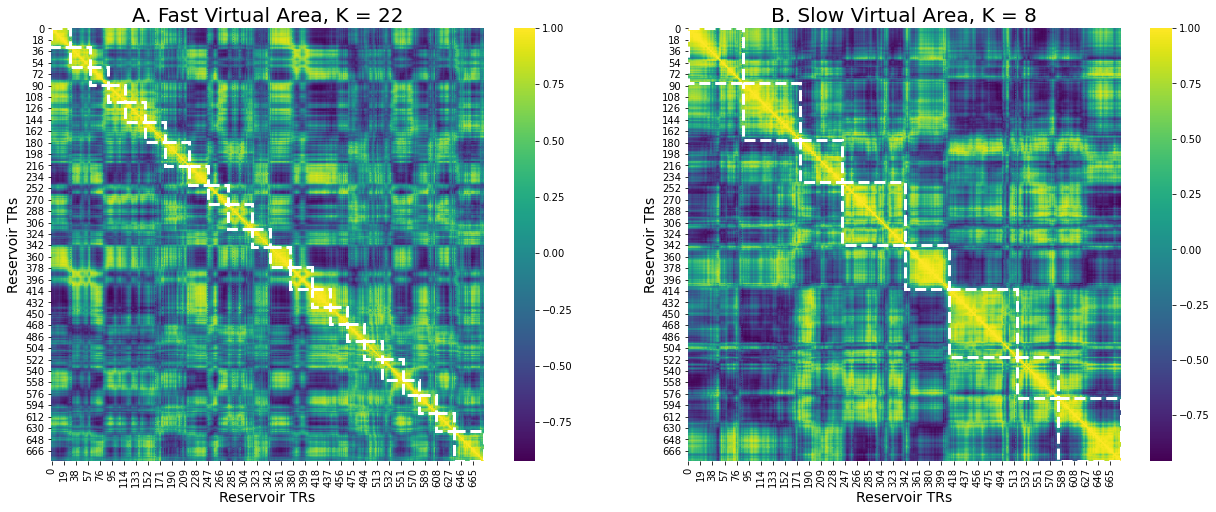

In [12]:
# 3 display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(18, 7))

fig.add_subplot(121)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(122)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)


fig.tight_layout()
plt.savefig('Exp4-june10.png')

In [13]:
tmatrix=np.zeros([kvalues,kvalues])
pmatrix=np.zeros([kvalues,kvalues])
dmatrix=np.zeros([kvalues,kvalues])
                  

In [29]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

for j in range(kvalues):
    for i in range(j):
        # when i < j
        anti = (likelihood[i,:,0]+ likelihood[j,:,1])/2 # small k with fast area + large k with slow area 
        pro = (likelihood[j,:,0]+ likelihood[i,:,1])/2  # large k with fast area + small k with slow area
        dmatrix[i,j]=np.mean(pro-anti)
        t,p = stats.ttest_rel(pro,anti)
        tmatrix[i,j]=t
        pmatrix[i,j]=p
        if  p< 0.01:
            print(i,j,t,p)


0 5 2.704925030841414 0.009370143322796952
1 5 3.2641270359125802 0.002005516650364061
0 6 3.4131595261623016 0.001296720737470467
1 6 3.9929479786602293 0.00021832026234211508
2 6 3.538150616989442 0.0008929418759172473
3 6 2.9711572135178224 0.004586830417095708
4 6 4.183361972891413 0.00011852216968130029
0 7 3.750911984305243 0.00046640549947291087
1 7 4.507432834381925 4.090227015559765e-05
2 7 3.8616278440578116 0.0003304195583457637
3 7 3.567179850499202 0.0008180754603028065
4 7 4.464331869341945 4.7195456792853615e-05
5 7 3.458288805217444 0.001134158063131753
0 8 3.4576366918188146 0.0011363623585168472
1 8 4.036303557790901 0.0001901633451438752
2 8 3.4573121734495675 0.001137460826494166
3 8 3.054111651947229 0.003644249792900505
4 8 3.474718536601465 0.0010799473286906315
0 10 3.1660490527262106 0.0026575616243280646
1 10 3.5130096639196 0.0009630283535223391
2 10 3.152967475728058 0.002758307896003203
3 10 2.7617130117941757 0.008071340320012391
4 10 2.9921583607745665 0.

(20, 20)
44
0.004134419804076599
0.005385881615209112


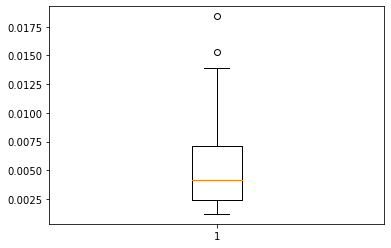

In [67]:
print(pmatrix.shape)
imin=0#1
imax=5
jmin=11
jmax=20
pmeans=np.zeros([(imax-imin)*(jmax-jmin)])
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

count=0
for i in range(imin,imax):
    for j in range(jmin,jmax):
        #print(i,j,pmatrix[i,j],count)
        pmeans[count]=pmatrix[i,j]
        count=count+1
print(count-1)
print(statistics.median(pmeans))
print(statistics.mean(pmeans))
plt.boxplot(pmeans)
plt.show()

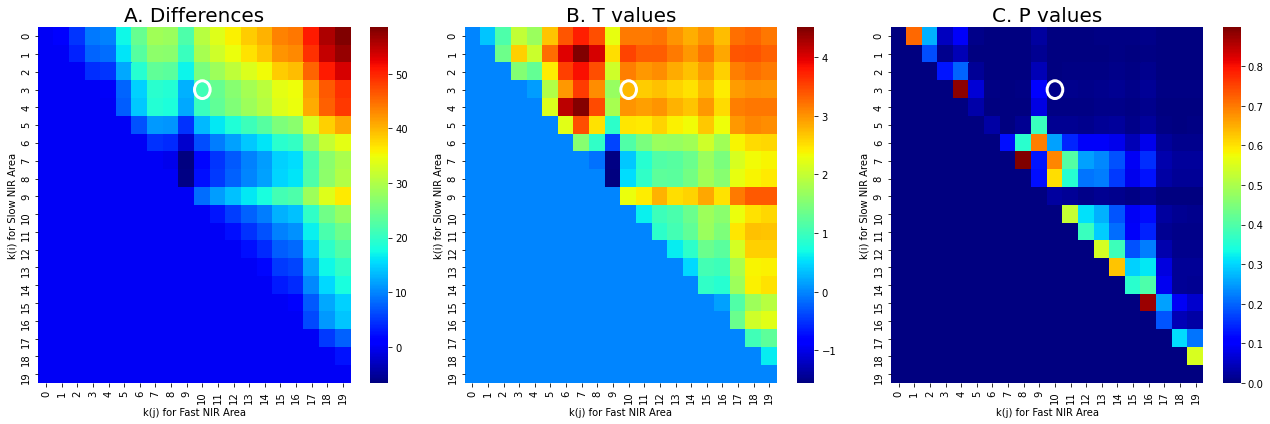

In [16]:
# 3 display the segmentation
color='jet'
ec='black'
scale=0.9
lw=2

fs1 = 14
fs2 = 20



fig=plt.figure(figsize=(18, 6))

fig.add_subplot(131)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('A. Differences', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(132)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(tmatrix, cmap=color)
plt.title('B. T values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(133)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('C. P values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.tight_layout()
plt.savefig('likelihoodk-areas-no-norm.png')

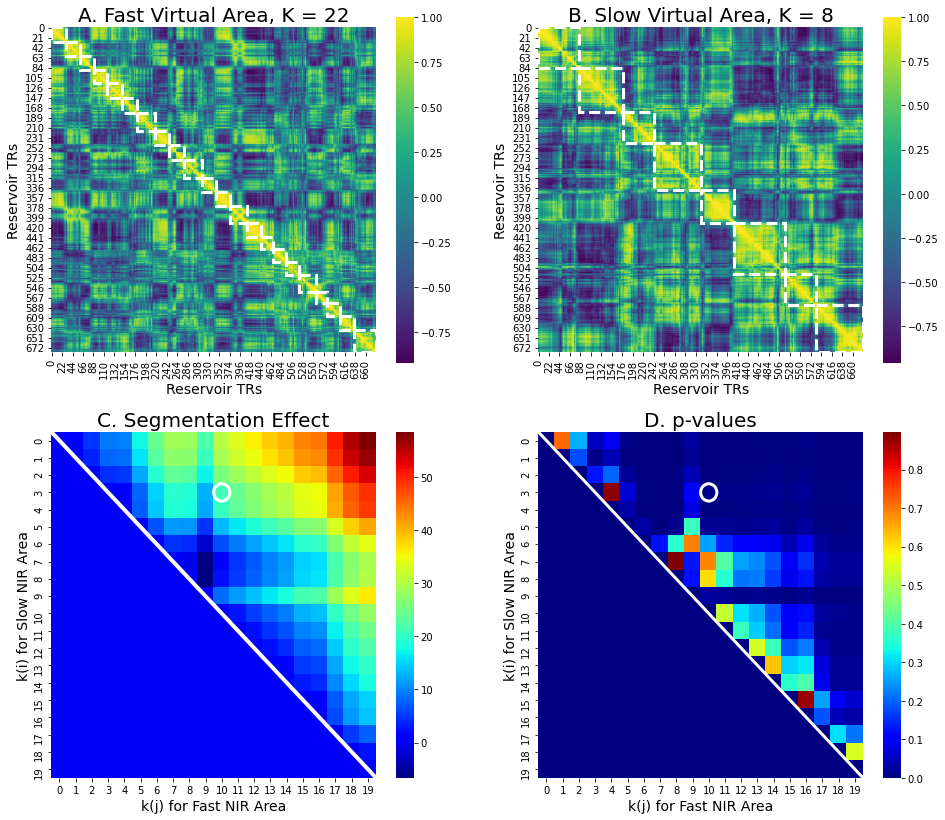

In [17]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################
color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('F10-Exp4-Combined.png', dpi=600)


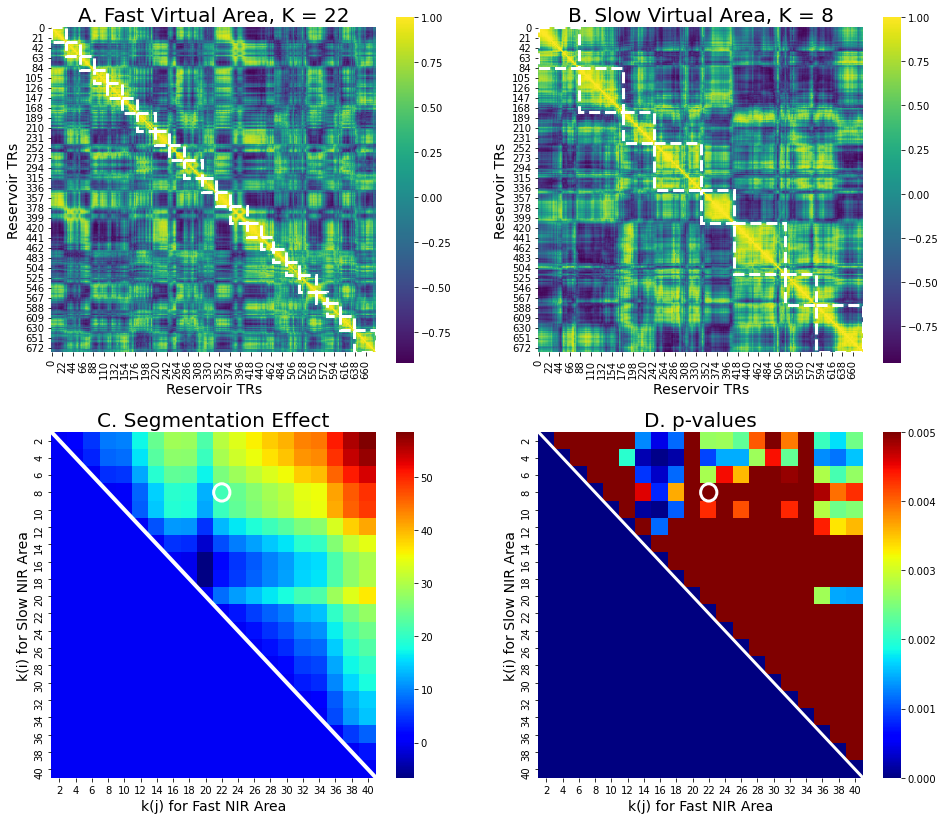

In [57]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_fit_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_fit_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################

A1 = np.linspace(2,40,20, dtype=int)
A2 = np.linspace(2,40,20, dtype=int)

color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color, xticklabels=A1, yticklabels=A2)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color, xticklabels=A1, yticklabels=A2,vmax = 0.005)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('F10-Exp4-ntf-fitting.png', dpi=600)


Text(0, 0.5, 'Log likelihood difference')

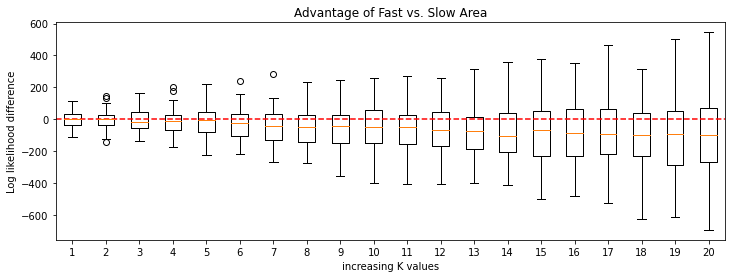

In [19]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# small K is slow, likelihood 1 is slow
# high K is fast, likelihood 0 is fast

#model k
#slow slow - fast slow
#slow fast - fast fast


f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.boxplot(likelihood[:,:,1].T-likelihood[:,:,0].T)
#ax.boxplot(likelihood[:,:,0].T)
#ax.boxplot(likelihood[:,:,1].T)
#ax.boxplot(likelihood)
#ax.plot(likelihood[:,1])

plt.axhline(y=0, color='r', linestyle='--')


ax.set_title('Advantage of Fast vs. Slow Area')
ax.set_xlabel('increasing K values')
ax.set_ylabel('Log likelihood difference')
#
#sns.despine()

(array([ 1.,  0.,  9., 10.,  9., 13.,  5.,  1.,  1.,  1.]),
 array([-1902.03500405, -1866.80909544, -1831.58318683, -1796.35727822,
        -1761.13136962, -1725.90546101, -1690.6795524 , -1655.45364379,
        -1620.22773519, -1585.00182658, -1549.77591797]),
 <BarContainer object of 10 artists>)

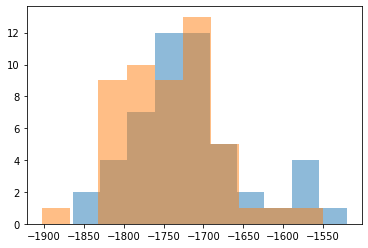

In [20]:
data3 = (likelihood[3,:,0]+ likelihood[10,:,1])/2
data4 = (likelihood[10,:,0]+ likelihood[3,:,1])/2

plt.hist(data4, alpha=0.5)
plt.hist(data3,alpha=0.5)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe3828eda50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe3828f5310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe3828ed690>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe3828f5bd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe38287f050>,
 'means': []}

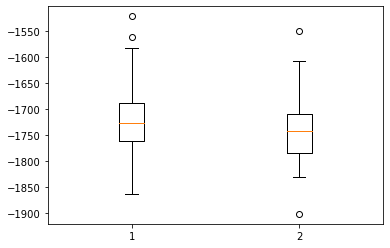

In [21]:
plt.boxplot([data4,data3])

In [22]:
#4 15 4.307048321216739 7.923701639107483e-05
t,p = stats.ttest_rel(data4,data3)
print(t)
print(p)
print(np.mean(data4-data3))

2.7617130117941757
0.008071340320012391
21.280288467730237


In [23]:
print(np.shape(likelihood))
print(kvalues)

(20, 50, 2)
20


<AxesSubplot:>

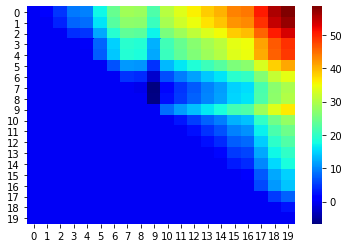

In [24]:
sns.heatmap(dmatrix,cmap='jet')

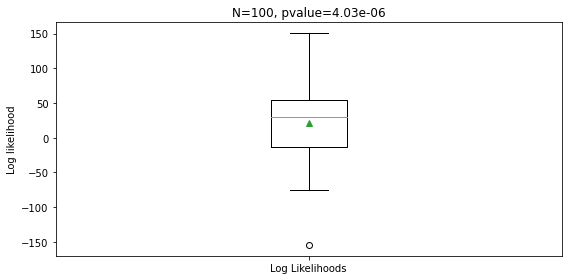

In [25]:

fig=plt.figure(figsize=(8, 4))
#f,ax = plt.subplots(1,1, figsize=(5, 5))
plt.boxplot(data4-data3,showmeans=True)
#plt.xlabel('Coherent                                    Incoherent')
plt.ylabel('Log likelihood')
#plt.axhline(y=0, color='r', linestyle='--')

plt.xticks([1], ['Log Likelihoods'])#ax.set_xticklabels(['Coherent-Incoherent'])
plt.title('N=100, pvalue=4.03e-06')
fig.tight_layout()
plt.savefig('temp2.png')

IndexError: index 25 is out of bounds for axis 0 with size 20

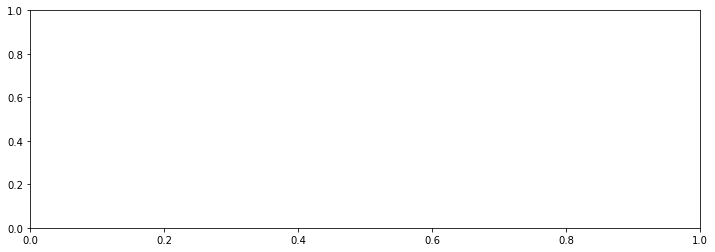

In [26]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(likelihood[4,:,0]-likelihood[25,:,1])
#ax.boxplot(likelihood)
#ax.plot(likelihood[:,1])

plt.axhline(y=0, color='r', linestyle='--')


ax.set_title('Advantage of Fast vs. Slow Area')
ax.set_xlabel('increasing K values')
ax.set_ylabel('Log likelihood difference')
#
#sns.despine()

In [ ]:
likelihood = np.load('likelihood-june10.npy')

In [ ]:
#np.save('NTF_fit-time1-june6.npy', NTF_fit_time1) 
#np.save('NTF_fit-time2-june6.npy', NTF_fit_time2) 

#np.save('likelihood-june6.npy', likelihood) 

NTF_fit_time1 = np.load('NTF_fit-time1-last-june10.npy')
NTF_fit_time2 = np.load('NTF_fit-time2-last-june10.npy')

In [ ]:
NTF_fit_time1 = np.load('NTF_fit-time1-june10.npy')
NTF_fit_time2 = np.load('NTF_fit-time2-june10.npy')